<a href="https://colab.research.google.com/github/shobhitsundriyal/time_series/blob/master/Cryptocurrency__price__prediction_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
sns.set(rc={'figure.figsize':(12, 8)})
sns.set(style='whitegrid', palette='muted')
RANDOM_SEED = 777
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [29]:
url = "https://query1.finance.yahoo.com/v7/finance/download/BTC-USD?period1=1279314000&period2=1556053200&interval=1d&events=history"
df = pd.read_csv(url, parse_dates=['Date'])
df = df.sort_values('Date')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [30]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1675,2019-04-19,5298.154297,5336.680176,5233.335449,5303.812500,5303.812500,13780238655
1676,2019-04-20,5304.160645,5358.490723,5295.877930,5337.886230,5337.886230,13169647522
1677,2019-04-21,5335.878906,5359.924805,5257.339355,5314.531250,5314.531250,13731844222
1678,2019-04-22,5312.494629,5422.687500,5280.276855,5399.365234,5399.365234,14601631647
1679,2019-04-23,5399.365723,5633.802246,5389.408691,5572.361816,5572.361816,15867308107


Closing Price. "Closing price" generally refers to the last price at which a stock trades during a regular trading session.</br>
So "Close" is our guy

(1680, 7)


Text(0, 0.5, 'Price(USD)')

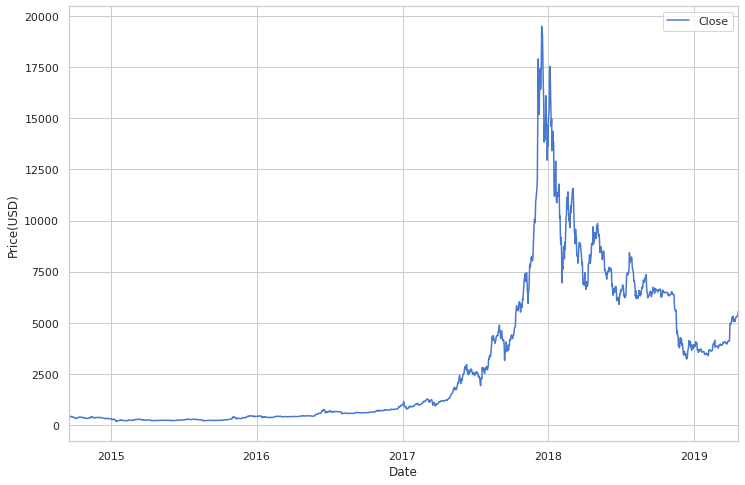

In [31]:
print(df.shape)
p = df.plot(x='Date', y='Close')
p.set_xlabel('Date')
p.set_ylabel('Price(USD)')

The freq. of this data => Daily


In [0]:
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()
close_price = df.Close.values.reshape(-1, 1)
scaled_close = scalar.fit_transform(close_price)

In [33]:
True in df.Close.isnull()

True

Ok there are some missing values so need to handle them

In [0]:
# Remove NaN values
scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_close = scaled_close.reshape(-1, 1)

---

#### Preparing Data and model Building

Lstm ip -> [batch_size, sequence_len, n_features]

In [0]:
seq_len = 100

In [0]:
def to_seq(data, seq_len):
  d = []

  for i in range(len(data) - seq_len):
    d.append(data[i: i + seq_len])
  
  d = np.array(d)
  print('Shape of data', d.shape)
  return d

def preprocess(original_data, seq_len, train_split):
  data = to_seq(original_data, seq_len)

  num_train = int(train_split * data.shape[0])

  x_train = data[:num_train, :-1, :]
  y_train = data[:num_train, -1, :]

  x_test = data[num_train:, :-1, :]
  y_test = data[num_train:, -1, :]

  return x_train, y_train, x_test, y_test

def plot_model_history(his):
  plt.plot(his.history['loss'])
  plt.plot(his.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [37]:
x_train, y_train, x_test, y_test = preprocess(scaled_close, seq_len, 0.95)

print('X_train shape = ', x_train.shape)

Shape of data (1580, 100, 1)
X_train shape =  (1501, 99, 1)


In [38]:
x_test.shape

(79, 99, 1)

##### Model Building

In [0]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM #Fast LSTM implementation backed by cuDNN

In [0]:
DROPOUT = 0.2
WINDOW_SIZE = seq_len - 1

model = Sequential()
model.add(Bidirectional( CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, x_train.shape[-1])
                        ))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional( CuDNNLSTM(WINDOW_SIZE * 2, return_sequences=True), ))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional( CuDNNLSTM(WINDOW_SIZE, return_sequences=False), ))

model.add(Dense(units=1))

model.add(Activation('linear'))

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 99, 198)           80784     
_________________________________________________________________
dropout_2 (Dropout)          (None, 99, 198)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 99, 396)           630432    
_________________________________________________________________
dropout_3 (Dropout)          (None, 99, 396)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 198)               393624    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 199       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                

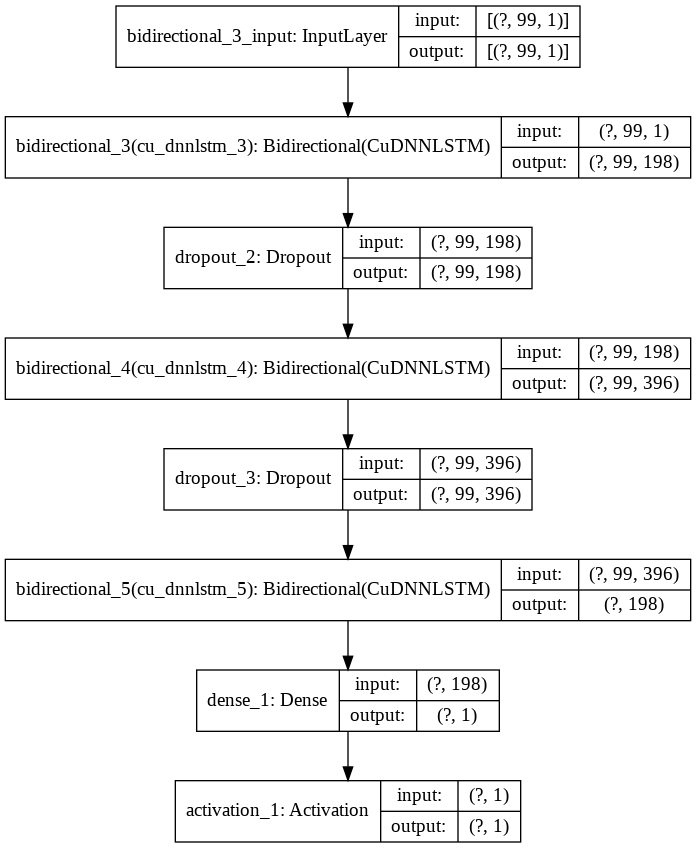

In [42]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True,)

In [43]:
batch_size = 64

model.compile(loss='mse', optimizer='Adam')
his = model.fit(x_train, y_train, epochs=50, batch_size=batch_size, shuffle=False
                , validation_split=0.1)

Epoch 1/50
22/22 [==============================] - 20s 918ms/step - loss: 0.0082 - val_loss: 0.0068
Epoch 2/50
22/22 [==============================] - 1s 50ms/step - loss: 0.0294 - val_loss: 0.0166
Epoch 3/50
22/22 [==============================] - 1s 48ms/step - loss: 0.0284 - val_loss: 0.0452
Epoch 4/50
22/22 [==============================] - 1s 48ms/step - loss: 0.0239 - val_loss: 0.0465
Epoch 5/50
22/22 [==============================] - 1s 48ms/step - loss: 0.0161 - val_loss: 0.0209
Epoch 6/50
22/22 [==============================] - 1s 48ms/step - loss: 0.0152 - val_loss: 0.0091
Epoch 7/50
22/22 [==============================] - 1s 48ms/step - loss: 0.0284 - val_loss: 0.0039
Epoch 8/50
22/22 [==============================] - 1s 48ms/step - loss: 0.0082 - val_loss: 0.0017
Epoch 9/50
22/22 [==============================] - 1s 48ms/step - loss: 0.0147 - val_loss: 0.0036
Epoch 10/50
22/22 [==============================] - 1s 48ms/step - loss: 0.0104 - val_loss: 0.0062
Epoch 1

In [44]:
model.evaluate(x_test, y_test)

3/3 [==============================] - 5s 2s/step - loss: 2.5683e-04


0.0002568313793744892

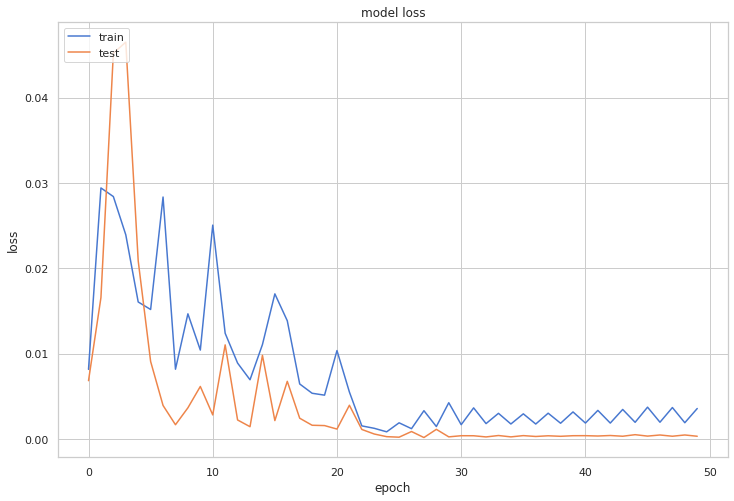

In [45]:
plot_model_history(his)

##### Prediction

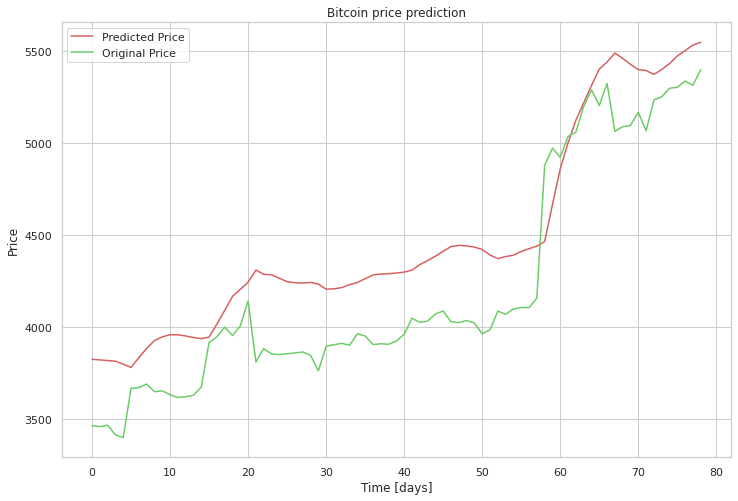

In [46]:
y_hat = model.predict(x_test)

# Get values on original scale
y_hat_inverse = scalar.inverse_transform(y_hat)
y_test_inverse = scalar.inverse_transform(y_test)

plt.plot(y_hat_inverse, label='Predicted Price', color='r')
plt.plot(y_test_inverse, label='Original Price', color='g')
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
plt.show()